# 分類問題

## オブジェクト指向のパーセプトロンAPI

---

In [25]:
import numpy as np

class Perceptron(object):
  """ パーセプトロンの分類機
  パラメーター
  ---------------------
  eta : float
      学習率 ( 0.0 より大きく 1.0 以下の値 )
  n_iter : int
      訓練データの訓練回数
  random_state : int
    重みを初期化するための乱数シード
  属性
  ---------------------
  w_ : １次元配列
      適合後のおもみ
  errors_ : リスト
      各エポックでの誤分類(更新)の数

  """
  def __init__(self, eta=0.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state
  
  def fit(self, X, y):
    """ 訓練データに適合させる
    パラメーター
    ---------------------
    X : { 配列のようなデータ構造 }, shape = {n_examples, n_features}
        訓練データ
        n_examplesは訓練データの個数, n_featuresは特徴量の個数
    y : 配列のようなデータ構造, shape = {n_examples}
        目的変数
    戻り値
    ---------------------
    self : object

    """
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.errors_ = []

    for _ in range(self.n_iter):
      errors = 0
      for xi, target in zip(X, y):
        update = self.eta * (target - self.predict(xi))
        self.w_[1:] += update * xi
        self.w_[0] += update
        errors += int(update != 0.0)
      self.errors_.append(errors)
    return self

  def net_input(self, X):
    """ 総入力を計算 """
    return np.dot(X, self.w_[1:]) + self.w_[0]

  def predict(self, X):
    """ 1ステップ後のクラスラベルを返す """
    return np.where(self.net_input(X) >= 0.0, 1, -1)
  

In [26]:
import os
import pandas as pd
s =os.path.join('https://archive.ics.uci.edu', 'ml', 'machine-learning-databases', 'iris','iris.data')
print('URL : ', s)
df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail()

URL :  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


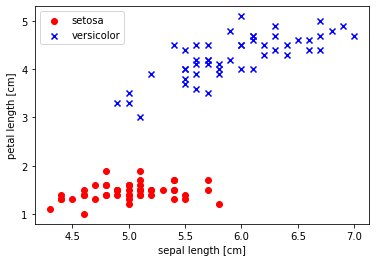

In [27]:
import matplotlib.pyplot as plt
#import numpy as np

# 目的変数の抽出 (1-100行, 4番目)
y = df.iloc[0:100, 4].values
# Iris-setosaを -1, Iris-virginicaを　１
y = np.where(y == 'Iris-setosa', -1 ,1)
# 目的変数の抽出 (1-100行, 1,3番目)
X = df.iloc[0:100, [0, 2]].values
# 品種setosaのプロット
plt.scatter(X[:50,0], X[:50,1], color='red', marker='o', label='setosa')
# 品種versicolorのプロット
plt.scatter(X[50:100,0], X[50:100,1], color='blue', marker='x', label='versicolor')
# 軸ラベル
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

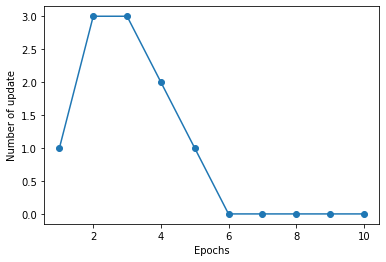

In [28]:
ppn = Perceptron(eta=0.1, n_iter=10)
# 訓練データへのモデルの適応
ppn.fit(X, y)
# エポックと誤分類の関係を表す折れ線グラフをプロット
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Number of update')
plt.show()

In [29]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

  # マーカーとカラーマップの準備
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # 決定領域のプロット
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  # グリッドポイントの生成
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
  # 各特徴料を1次元配列に変換して予測を実行
  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  # 予測結果を元のグリッドポイントのデータサイズに変換
  Z = Z.reshape(xx1.shape)
  # グリッドポイントの等高線のプロット
  plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
  # 軸の範囲の設定
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  # クラスごとに訓練データをプロット
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0],
                y=X[y == cl, 1],
                alpha=0.8,
                c=colors[idx],
                marker=markers[idx],
                label=cl,
                edgecolor='black'
                )

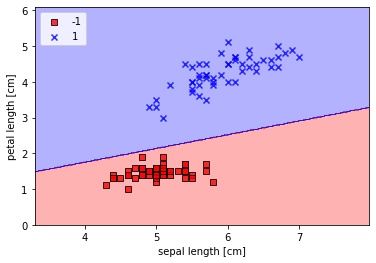

In [30]:
# 決定領域のプロット
plot_decision_regions(X, y, classifier=ppn)
# 軸ラベル
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()



## ADALINEと学習の収束 (バッチ勾配降下法)

---



In [31]:
class AdalineGD(object):
  """ADAptive LIner NEuron 分類機
  パラメーター
  ---------------------
  eta : float
      学習率 ( 0.0 より大きく 1.0 以下の値 )
  n_iter : int
      訓練データの訓練回数
  random_state : int
    重みを初期化するための乱数シード
  属性
  ---------------------
  w_ : １次元配列
      適合後のおもみ
  cost_ : リスト
      各エポックでの誤差平方和のコスト関数

  """

  def __init__(self, eta=0.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state
  
  def fit(self, X, y):
    """ 訓練データに適合させる
    パラメーター
    ---------------------
    X : { 配列のようなデータ構造 }, shape = {n_examples, n_features}
        訓練データ
        n_examplesは訓練データの個数, n_featuresは特徴量の個数
    y : 配列のようなデータ構造, shape = {n_examples}
        目的変数

    戻り値
    ---------------------
    self : object

    """
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
      net_input = self.net_input(X)
      output = self.activation(net_input)
      errors = ( y - output )
      self.w_[1:] += self.eta * X.T.dot(errors)
      self.w_[0] += self.eta * errors.sum()
      cost = (errors**2).sum() / 2.0
      self.cost_.append(cost)
    return self

  def net_input(self, X):
    """ 総入力を計算 """
    return np.dot(X, self.w_[1:]) + self.w_[0]

  def activation(self, X):
    """ 線形活性化関数の出力を計算 """
    return X

  def predict(self, X):
    """ 1ステップ後のクラスラベルを返す """
    return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

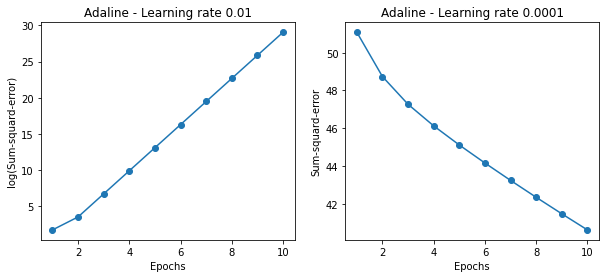

In [32]:
# エポック数に対するコストプロット
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ada1= AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_)+1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squard-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2= AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_)+1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squard-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

### 標準化

$$
x_{j}^{\prime} = \frac{x_{j} - \mu_{j}}{\sigma_{j}}
$$

> $\sigma_{j}$ : 訓練データの平均
> 
> $x_{j}^{\prime}$ : 訓練データのj番目における特徴量ベクトル
> 
> $\sigma_{j}$ : 標準偏差





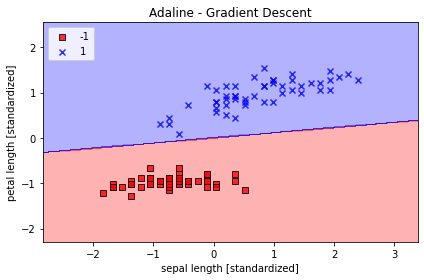

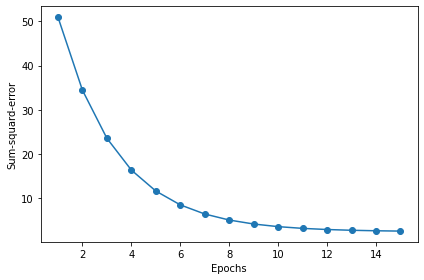

In [33]:
 # データのコピー
 X_std = np.copy(X)
 X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
 X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

ada_gd = AdalineGD(n_iter=15, eta=0.01)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_gd.cost_) + 1), ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squard-error')
plt.tight_layout()
plt.show()

## 確立的勾配降下法

---



In [36]:
from numpy.random import seed

class AdalineSGD(object):
  """ADAptive LIner NEuron 分類機
  パラメーター
  ---------------------
  eta : float
      学習率 ( 0.0 より大きく 1.0 以下の値 )
  n_iter : int
      訓練データの訓練回数
  shuffle : bool (デフォルト : True)
    Trueの場合は、循環を回避するためにエポックごとに訓練データをシャッフル
  random_state : int
    重みを初期化するための乱数シード

  属性
  ---------------------
  w_ : １次元配列
      適合後のおもみ
  cost_ : リスト
      各エポックでの誤差平方和のコスト関数

  """

  def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
    self.eta = eta
    self.n_iter = n_iter
    self.w_initialized = False
    self.shuffle = shuffle
    self.random_state = random_state

  def fit(self, X, y):
    """ 訓練データに適合させる
    パラメーター
    ---------------------
    X : { 配列のようなデータ構造 }, shape = {n_examples, n_features}
        訓練データ
        n_examplesは訓練データの個数, n_featuresは特徴量の個数
    y : 配列のようなデータ構造, shape = {n_examples}
        目的変数

    戻り値
    ---------------------
    self : object

    """
    self._initialize_weights(X.shape[1])
    self.cost_ = []
    for i in range(self.n_iter):
      if self.shuffle:
        X, y = self._shuffle(X, y)
      cost = []
      for xi, target in zip(X, y):
        cost.append(self._update_weights(xi, target))
      avg_cost = sum(cost) / len(y)
      self.cost_.append(avg_cost)
    return self

  def  partial_fit(self, X, y):
    """ 重みを再初期化することなく訓練データに適合させる """
    if not self.w_initialized:
      self._initialize_weights(X.shape[1])
    if y.ravel().shape[0] > 1:
      for xi, target in zip(X, y):
        self._update_weights(xi, target)
    else:
      self._update_weights(X, y)
    return self
  
  def _shuffle(self, X, y):
    """ 訓練データをシャッフル """
    r = self.rgen.permutation(len(y))
    return X[r], y[r]
  
  def _initialize_weights(self, m):
    """ 重みを小さな乱数に初期化 """
    self.rgen = np.random.RandomState(self.random_state)
    self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
    self.w_initialized = True
  
  def _update_weights(self, xi, target):
    """ ADALINEの学習規則を用いて重みを更新 """
    output = self.activation(self.net_input(xi))
    error = (target - output)
    self.w_[1:] += self.eta * xi.dot(error)
    self.w_[0] += self.eta * error
    cost = 0.5 * error**2
    return cost
  
  def net_input(self, X):
    """ 総入力を計算 """
    return np.dot(X, self.w_[1:] ) + self.w_[0]
  
  def activation(self, X):
    """ 線形活性化関数の出力を計算 """
    return X

  def predict(self, X):
    """ 1ステップ後のクラスラベルを返す """
    return np.where(self.activation(self.net_input(X) ) >= 0.0, 1, -1)



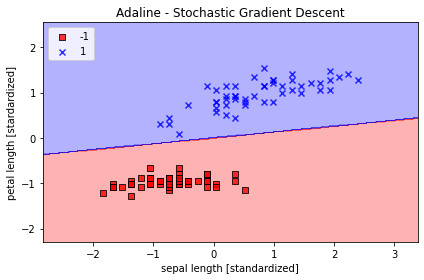

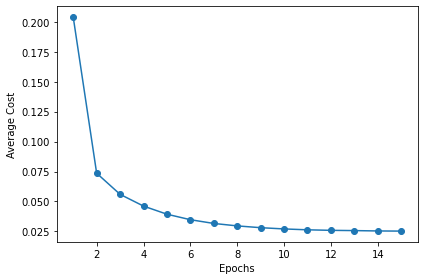

In [37]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [stardardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot( range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()